In [2]:
import cv2
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
# from keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from keras.utils import plot_model
import os

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7127539484027538283
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3660972032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 455961409962282898
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [ ]:
pwd

Not working

In [8]:
## Data Augmentation
## It was chosen the resolution of 1536x1024px keep the ratio of the original images (6000x4000px). 

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def augment_data(images, masks, save_path, augment=True):
    H = 1024
    W = 1536
    for x,y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]       
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        y = cv2.imread(y, cv2.IMREAD_COLOR)
        y = cv2.resize(y, (W, H))
        
        if augment == True:
            
            aug = RandomCrop(int(2*H/3), int(2*W/3), always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]
 
            aug = HorizontalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]
            
            aug = VerticalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"] 
            
            save_images = [x, x1, x2, x3]
            save_masks = [y, y1, y2, y3]            
          
        else:
            save_images = [x]
            save_masks = [y]
        
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            
            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}" 
            
            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_msk_name)
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx+=1

path = "../data/dataset/semantic_drone_dataset"
images = sorted(glob(os.path.join(path, "original_images/*")))
masks = sorted(glob(os.path.join(path, "label_images_semantic/*")))
print(f"Original images:  {len(images)} - Original masks: {len(masks)}")

create_dir("../data/dataset/semantic_drone_dataset/new_data/images/")
create_dir("../data/dataset/semantic_drone_dataset/new_data/masks/")

save_path = "../data/dataset/semantic_drone_dataset/new_data/"

augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

Original images:  400 - Original masks: 400


100%|██████████| 400/400 [03:31<00:00,  1.89it/s]

Augmented images:  0 - Augmented masks: 0


In [4]:
path = "../data/dataset/semantic_drone_dataset"
images = sorted(glob(os.path.join(path, "original_images/*")))
masks = sorted(glob(os.path.join(path, "label_images_semantic/*")))
print(f"Original images:  {len(images)} - Original masks: {len(masks)}")

Original images:  400 - Original masks: 400


In [5]:
## Create dataframe

image_path =  os.path.join(path, "original_images/")
label_path = os.path.join(path, "label_images_semantic/")

def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

Total Images:  400


In [6]:
## Split data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19)
X_trainval=df_images['id']
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Train Size : 320 images
Val Size   :  80 images
Test Size  :  40 images


In [7]:
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def mobileunet(input_size, num_classes):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)    
    
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)
    
    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)
    
    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)
    
    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)    
    conv8  = BatchNormalization()(conv8)
    
    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)        
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    output = conv10
    return Model(inputs, output)

In [11]:
## Define the resolution of the images and the number of classes


#H = 768   #to keep the original ratio 
#W = 1152 
H = 4000   #to keep the original ratio 
W = 6000 
num_classes = 23

#model = build_unet((W, H, 3), num_classes)  
model = mobileunet((W, H, 3),num_classes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1152, 768, 3 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 1152, 768, 64 283         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1152, 768, 64 256         separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 1152, 768, 64 4736        batch_normalization[0][0]        
______________________________________________________________________________________________

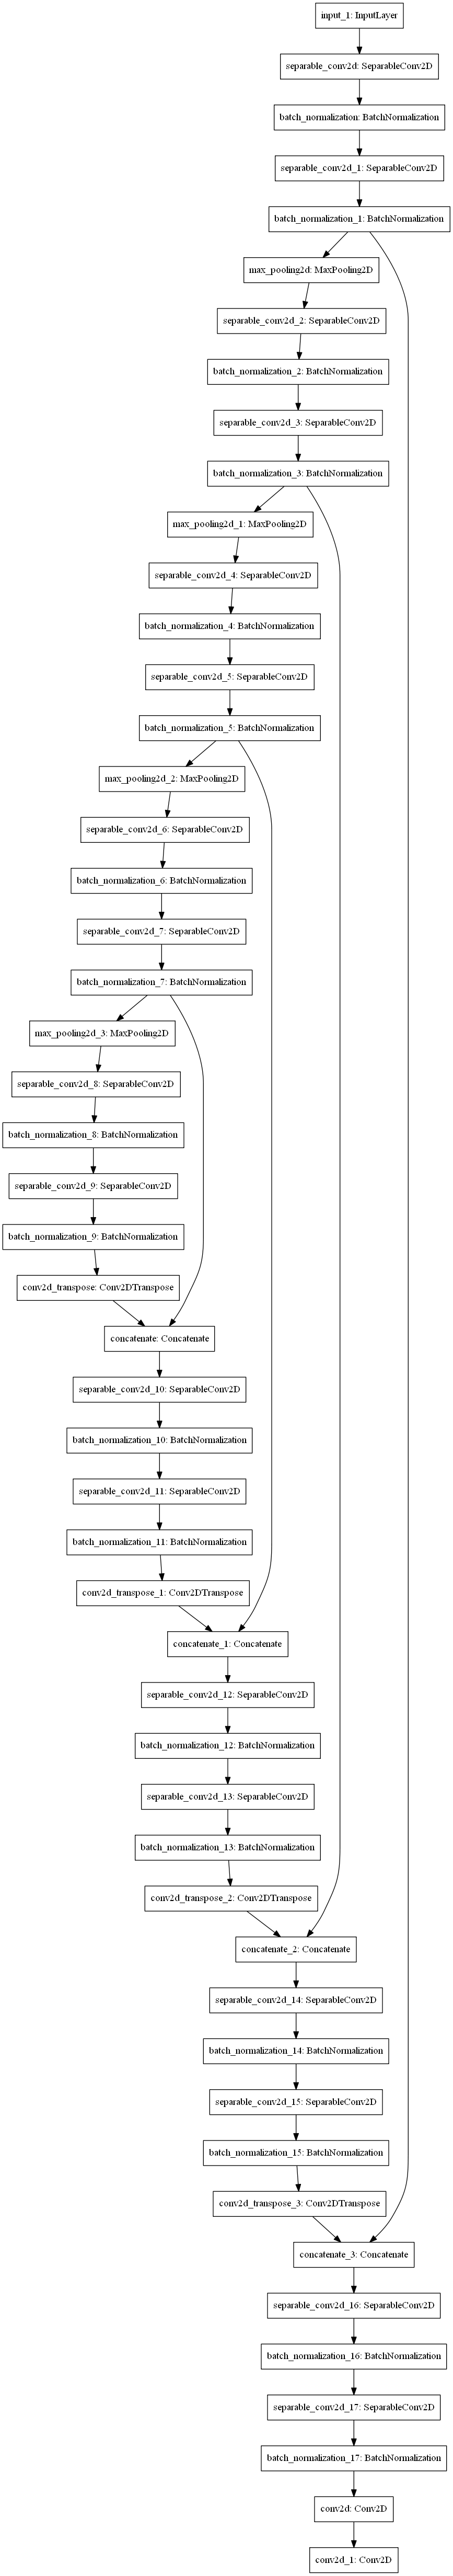

In [14]:
from keras.utils import plot_model
model.summary()
plot_model(model,to_file='model.png')

In [12]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

In [13]:
## Train the model

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
shape = (H, W, 3)
num_classes = 23  
lr = 1e-4
batch_size = 4
epochs = 20

# Model
model = mobileunet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

checkpointer = [
    ModelCheckpoint(filepath="./model.h5",monitor='val_loss',verbose=2,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=2)
]

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=checkpointer
         )

Epoch 1/20


In [ ]:
## Prediction

create_dir('./results')  #create the folder for the predictions

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Model
model = tf.keras.models.load_model("model.h5")

# Saving the masks
for x, y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    
    ## Read image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)

    ## Read mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    
    y = np.expand_dims(y, axis=-1) #(384,256,1)
    
    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)
    
    ## Prediction
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    
    p = np.expand_dims(p, axis=-1)  
    
    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)
      
    cv2.imwrite(f"./results/{name}", p)

In [ ]:
## Plot 5 images to verify the accuracy in the predictions

img_selection = image_list[10:15]
mask_selection = mask_list[10:15]

for img, mask in zip(img_selection, mask_selection):
    name = img.split("/")[-1]
    x = cv2.imread(img, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (W, H))

    y = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))


    p = cv2.imread(f"./results/{name}", cv2.IMREAD_GRAYSCALE)
    p = cv2.resize(p, (W, H))

    #Plotto le tre immagini
    fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

    axs[0].imshow(x, interpolation = 'nearest')
    axs[0].set_title('image')
    axs[0].grid(False)

    axs[1].imshow(y, interpolation = 'nearest')
    axs[1].set_title('GT')
    axs[1].grid(False)

    axs[2].imshow(p)
    axs[2].set_title('prediction')
    axs[2].grid(False)